In [54]:
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pygeoda
import statsmodels.api as sm
# from sklearn.linear_model import LinearRegression

In [3]:
path = "~/Documents/spatial_clustering/final_project/data/"
    # get census data
census_df = gpd.read_file(
    path + "census_tracts/geo_export_a19e0577-c0ec-456a-8bea-703d57c3459d.shp"
)

# get full bus schedule per week
schedule_df = pd.read_csv(path + "google_transit/stop_times.txt")

# get bus stop point data
bus_point_df = gpd.read_file(path + "CTA_BusStops/CTA_BusStops.shp")
bus_point_df["SYSTEMSTOP"] = bus_point_df["SYSTEMSTOP"].astype(int)

stop_counts = schedule_df.groupby("stop_id").size().reset_index(name="stop_count")
bus_df_2 = bus_point_df.copy()
bus_df_2 = pd.merge(
    bus_df_2, stop_counts, how="inner", left_on="SYSTEMSTOP", right_on="stop_id"
)

census_bus_crs_df = census_df.to_crs(bus_df_2.crs)

stops_census_df = gpd.sjoin(bus_df_2, census_bus_crs_df, how="inner", op="intersects")
point_sum_df = (
    stops_census_df.groupby("geoid10")["stop_count"].sum().reset_index(name="count")
)
point_sum_df["count"] = point_sum_df["count"].astype(float)
point_sum_gdf = gpd.GeoDataFrame(
    point_sum_df, geometry=gpd.GeoSeries(census_bus_crs_df["geometry"])
)

breaks15 = pygeoda.hinge15_breaks(point_sum_gdf["count"])


/Users/meganmoore/miniconda3/envs/transit_clustering/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3517: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


In [4]:
point_sum_gdf

,geoid10,count,geometry
0,17031010100,250.0,"POLYGON ((-87.62405 41.73022, -87.62405 41.730..."
1,17031010201,597.0,"POLYGON ((-87.68608 41.82296, -87.68607 41.823..."
2,17031010202,3834.0,"POLYGON ((-87.62935 41.85280, -87.62934 41.852..."
3,17031010300,3297.0,"POLYGON ((-87.68813 41.85569, -87.68816 41.856..."
4,17031010400,3561.0,"POLYGON ((-87.63312 41.87449, -87.63306 41.874..."
...,...,...,...
791,17031843600,3141.0,"POLYGON ((-87.65491 41.79599, -87.65490 41.795..."
792,17031843700,5760.0,"POLYGON ((-87.65012 41.79823, -87.65011 41.797..."
793,17031843800,4324.0,"POLYGON ((-87.71347 41.79565, -87.71347 41.795..."
794,17031843900,14757.0,"POLYGON ((-87.73306 41.79661, -87.73282 41.796..."


In [5]:
census_df.columns

Index(['commarea', 'commarea_n', 'countyfp10', 'geoid10', 'name10',
       'namelsad10', 'notes', 'statefp10', 'tractce10', 'geometry'],
      dtype='object')

In [17]:
# might not need all demographic inforrmation
# census_dems = pd.read_csv(path + "demographics/tract_allindicators_allSubgroups.csv")
#census_dems = pd.read_csv(path + "demographics/HHPULSETIMESERIES.HPS01-Data.csv")

In [20]:
employment = pd.read_csv(path + 'demographics/tract_ann_avg_job_growth_2004_2013.csv')

In [29]:
census_tracts = list(point_sum_gdf.loc[:, 'geoid10'].unique())
employment['tract'] = employment['tract'].astype(str)
chi_emp = employment.loc[employment.loc[:, 'tract'].isin(census_tracts), :]

<Axes: >

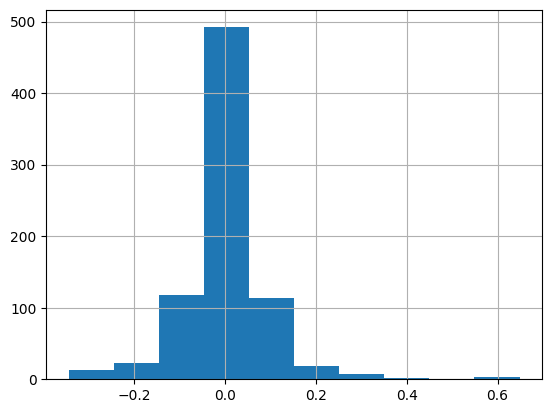

In [47]:
chi_emp['Job_Growth_Rate_from_2004_to_2013'].hist()

In [44]:

min_value = point_sum_df['count'].min()
max_value = point_sum_df['count'].max()

diff = max_value - min_value

# Rescale the column
point_sum_df['rescaled_counts'] = (2 * (point_sum_df['count'] - min_value) / diff) - 1

In [45]:
point_sum_df['rescaled_counts']

0     -0.990286
1     -0.966209
2     -0.741604
3     -0.778865
4     -0.760547
         ...   
791   -0.789689
792   -0.607966
793   -0.707605
794    0.016306
795   -0.579170
Name: rescaled_counts, Length: 796, dtype: float64

In [50]:
emp_stats = pd.merge(chi_emp, point_sum_df, how='inner', left_on = 'tract', right_on ='geoid10')

In [51]:
emp_stats

,tract,Name,Job_Growth_Rate_from_2004_to_2013,geoid10,count,rescaled_counts
0,17031240700,"West Town, Chicago, IL",0.1590,17031240700,815.0,-0.951082
1,17031730400,"South Side, Chicago, IL",0.1105,17031730400,5690.0,-0.612823
2,17031750200,"South Side, Chicago, IL",-0.0121,17031750200,1358.0,-0.913405
3,17031671600,"Englewood, Chicago, IL",0.0767,17031671600,2819.0,-0.812032
4,17031242900,"West Town, Chicago, IL",0.0267,17031242900,2060.0,-0.864696
...,...,...,...,...,...,...
791,17031271300,"East Garfield Park, Chicago, IL",-0.3449,17031271300,4308.0,-0.708715
792,17031841600,"Lawndale, Chicago, IL",NaN,17031841600,714.0,-0.958090
793,17031420600,"South Side, Chicago, IL",NaN,17031420600,2420.0,-0.839717
794,17031671800,"Englewood, Chicago, IL",NaN,17031671800,575.0,-0.967735


In [60]:
# reg = LinearRegression()
# df_cleaned = emp_stats.dropna(subset=['Job_Growth_Rate_from_2004_to_2013'])
# model = reg.fit(df_cleaned[['count']], df_cleaned['Job_Growth_Rate_from_2004_to_2013'])

In [91]:
df_cleaned = emp_stats.dropna(subset=['Job_Growth_Rate_from_2004_to_2013'])
X = df_cleaned['count']
y = df_cleaned['Job_Growth_Rate_from_2004_to_2013']

# Add a constant term to the independent variable
X = sm.add_constant(X)

# Fit the linear regression model
model = sm.OLS(y, X).fit()

# Get the summary of the regression
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  count   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                 0.0004753
Date:                Mon, 04 Mar 2024   Prob (F-statistic):              0.983
Time:                        21:58:06   Log-Likelihood:                -7310.9
No. Observations:                 792   AIC:                         1.463e+04
Df Residuals:                     790   BIC:                         1.464e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
const 

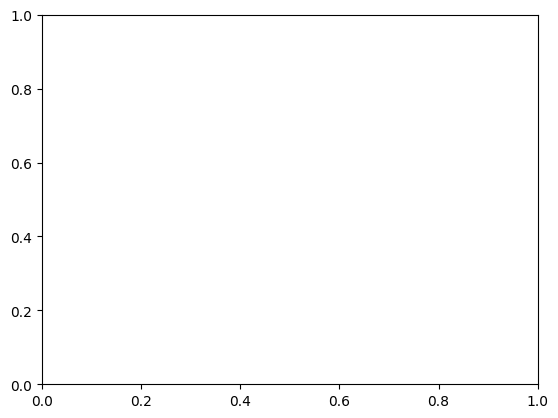

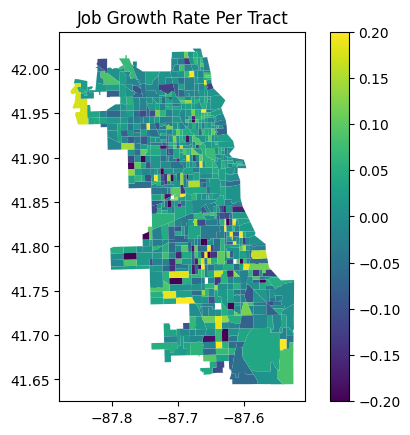

In [131]:
emp_geo = census_df.merge(emp_stats[['Job_Growth_Rate_from_2004_to_2013', 'geoid10']], on='geoid10')
fig, ax = plt.subplots()
emp_geo[['Job_Growth_Rate_from_2004_to_2013', "geometry"]].plot('Job_Growth_Rate_from_2004_to_2013', legend=True, vmax=0.2, vmin=-0.2)
plt.title("Job Growth Rate Per Tract")
plt.savefig("../figures/job_growth_per_tract.png")
plt.show()


In [72]:
inc = pd.read_csv(path + 'demographics/tract_kfr_allSubgroups.csv')

In [74]:
inc['tract'].astype(int)

0        30111000300
1        30013000700
2        46103010500
3        40031001500
4        19193001500
            ...     
73497    47037015629
73498    48113980000
73499     6073021302
73500     4013615800
73501    13297110602
Name: tract, Length: 73502, dtype: int64

In [75]:
census_tracts = list(point_sum_gdf.loc[:, 'geoid10'].unique())
inc['tract'] = inc['tract'].astype(int).astype(str)
chi_inc = inc.loc[inc.loc[:, 'tract'].isin(census_tracts), :]

In [80]:
# there are only 160 census tracts that have household income information
len(list(chi_inc['kfr_rA_gP_pall'].unique()))

160

In [102]:
chi_inc['kfr_rA_gP_pall'].min()

33258.0

In [83]:
inc_stats = pd.merge(chi_inc, point_sum_df, how='inner', left_on = 'tract', right_on ='geoid10')

In [100]:
df_cleaned = inc_stats.dropna(subset=['kfr_rA_gP_pall'])
X = df_cleaned['count']
y = df_cleaned['kfr_rA_gP_pall']

# Add a constant term to the independent variable
X = sm.add_constant(X)

# Fit the linear regression model
inc_model = sm.OLS(y, X).fit()

# Get the summary of the regression
print(inc_model.summary())

                            OLS Regression Results                            
Dep. Variable:         kfr_rA_gP_pall   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                 -0.005
Method:                 Least Squares   F-statistic:                    0.2903
Date:                Mon, 04 Mar 2024   Prob (F-statistic):              0.591
Time:                        22:04:47   Log-Likelihood:                -1696.6
No. Observations:                 159   AIC:                             3397.
Df Residuals:                     157   BIC:                             3403.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       5.582e+04   1163.811     47.962      0.0

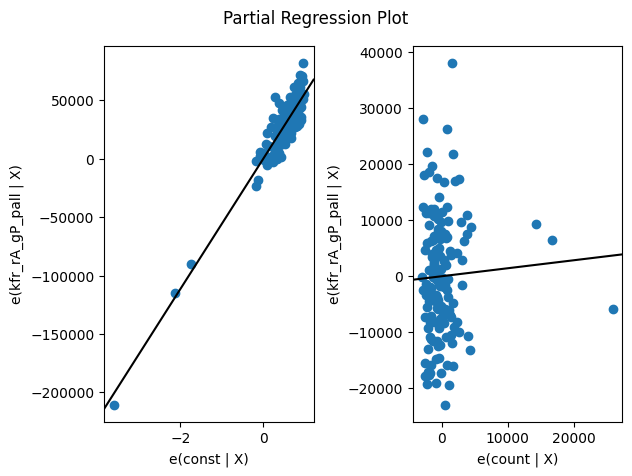

In [101]:
fig = sm.graphics.plot_partregress_grid(inc_model)
fig.tight_layout(pad=1.0)

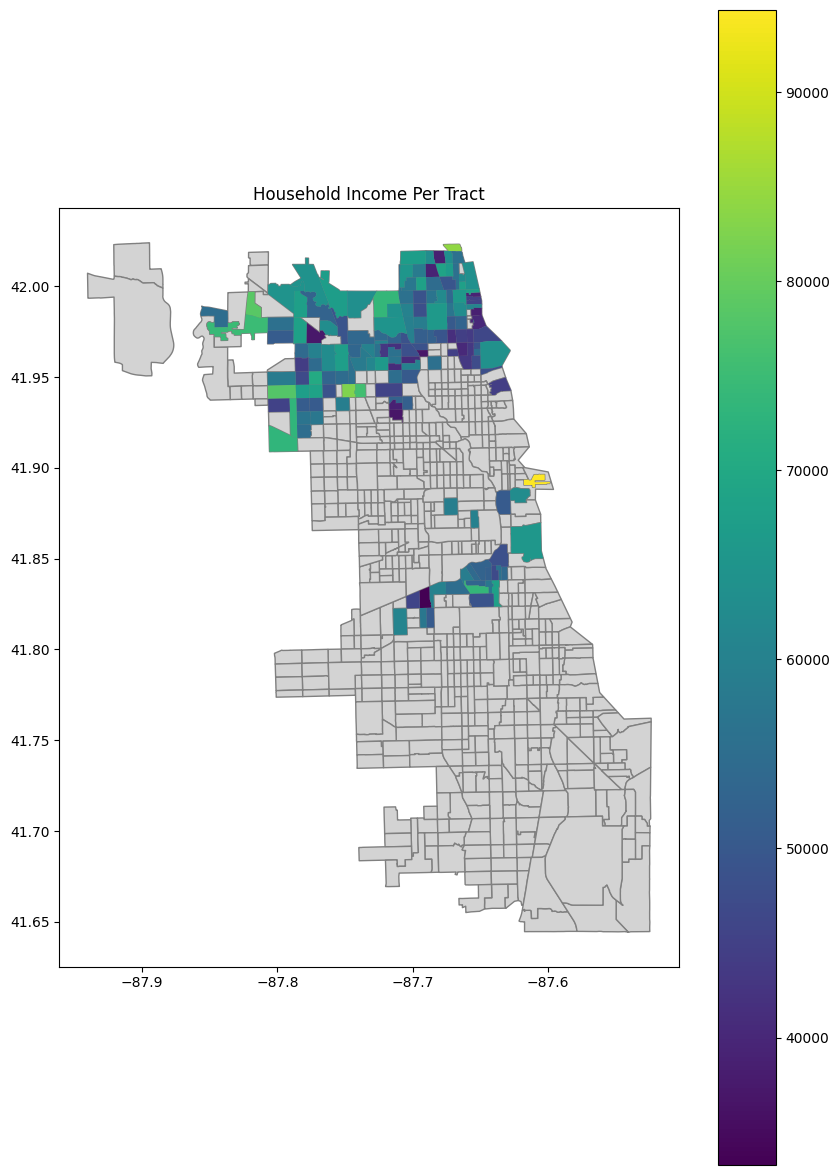

In [147]:
inc_geo = census_df.merge(inc_stats[['kfr_rA_gP_pall', 'geoid10']], on='geoid10', how='outer')
fig, ax = plt.subplots(figsize=(10, 15))
inc_geo[["geometry"]].plot(ax=ax, color='lightgrey', edgecolor='grey')
inc_geo[['kfr_rA_gP_pall', "geometry"]].plot('kfr_rA_gP_pall', ax=ax, legend=True)
plt.title("Household Income Per Tract")
plt.savefig("../figures/household_income_per_tract.png")
plt.show()

In [104]:

incarceration = pd.read_csv(path + 'demographics/tract_jail_rP_gP_pall.csv')

In [105]:
census_tracts = list(point_sum_gdf.loc[:, 'geoid10'].unique())
incarceration['tract'] = incarceration['tract'].astype(int).astype(str)
chi_incarceration = incarceration.loc[incarceration.loc[:, 'tract'].isin(census_tracts), :]
incarceration_stats = pd.merge(chi_incarceration, point_sum_df, how='inner', left_on = 'tract', right_on ='geoid10')

In [106]:
incarceration_stats

,tract,Name,Incarceration_Rate_rP_gP_pall,geoid10,count,rescaled_counts
0,17031612100,"South Side, Chicago, IL",0.1205,17031612100,2138.0,-0.859284
1,17031290900,"Lawndale, Chicago, IL",0.1175,17031290900,3515.0,-0.763739
2,17031350400,"Douglas, Chicago, IL",0.1149,17031350400,1070.0,-0.933389
3,17031381400,"South Side, Chicago, IL",0.1090,17031381400,1916.0,-0.874688
4,17031271300,"East Garfield Park, Chicago, IL",0.1060,17031271300,4308.0,-0.708715
...,...,...,...,...,...,...
791,17031061100,"Wrigleyville, Chicago, IL",NaN,17031061100,1239.0,-0.921663
792,17031980100,"Clearing, Chicago, IL",NaN,17031980100,6175.0,-0.579170
793,17031063303,"Lake View East, Chicago, IL",NaN,17031063303,863.0,-0.947752
794,17031835700,"Bronzeville, Chicago, IL",NaN,17031835700,1142.0,-0.928393


In [148]:
df_cleaned = incarceration_stats.dropna(subset=['Incarceration_Rate_rP_gP_pall'])
X = df_cleaned['count']
y = df_cleaned['Incarceration_Rate_rP_gP_pall']

# Add a constant term to the independent variable
X = sm.add_constant(X)

# Fit the linear regression model
incarceration_model = sm.OLS(y, X).fit()

# Get the summary of the regression
print(incarceration_model.summary())

                                  OLS Regression Results                                 
Dep. Variable:     Incarceration_Rate_rP_gP_pall   R-squared:                       0.006
Model:                                       OLS   Adj. R-squared:                  0.005
Method:                            Least Squares   F-statistic:                     5.100
Date:                           Tue, 05 Mar 2024   Prob (F-statistic):             0.0242
Time:                                   17:02:41   Log-Likelihood:                 1792.9
No. Observations:                            791   AIC:                            -3582.
Df Residuals:                                789   BIC:                            -3573.
Df Model:                                      1                                         
Covariance Type:                       nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
---------------------

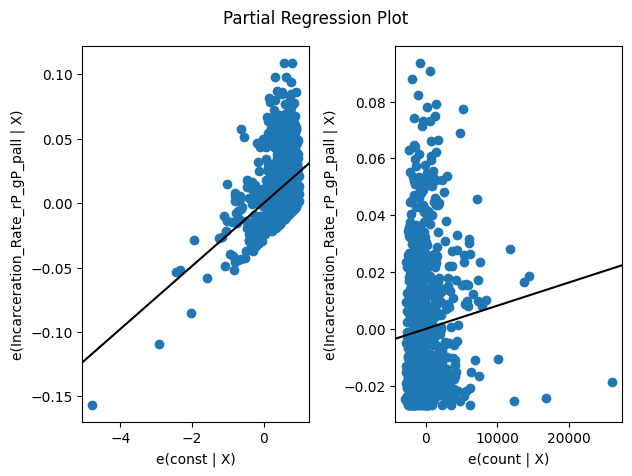

In [109]:
fig = sm.graphics.plot_partregress_grid(incarceration_model)
fig.tight_layout(pad=1.0)

8.168430794570631e-07


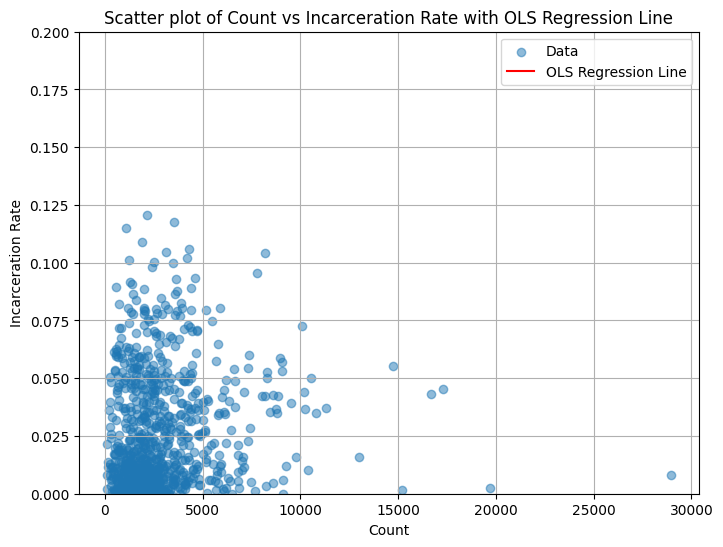

In [122]:
x = df_cleaned['count']
y = df_cleaned['Incarceration_Rate_rP_gP_pall']

coefficients = np.polyfit(x, y, 1)
intercept, slope = coefficients
print(intercept)
plt.figure(figsize=(8, 6))
plt.scatter(x, y, alpha=0.5, label='Data')  

plt.plot(x, (slope * x*10), color='red', label='OLS Regression Line')

plt.ylim(0, 0.2)
plt.title('Scatter plot of Count vs Incarceration Rate with OLS Regression Line')
plt.xlabel('Count')
plt.ylabel('Incarceration Rate')
plt.grid(True)
plt.legend()
plt.show()

In [113]:
df_cleaned['Incarceration_Rate_rP_gP_pall']

0.026824905183312264

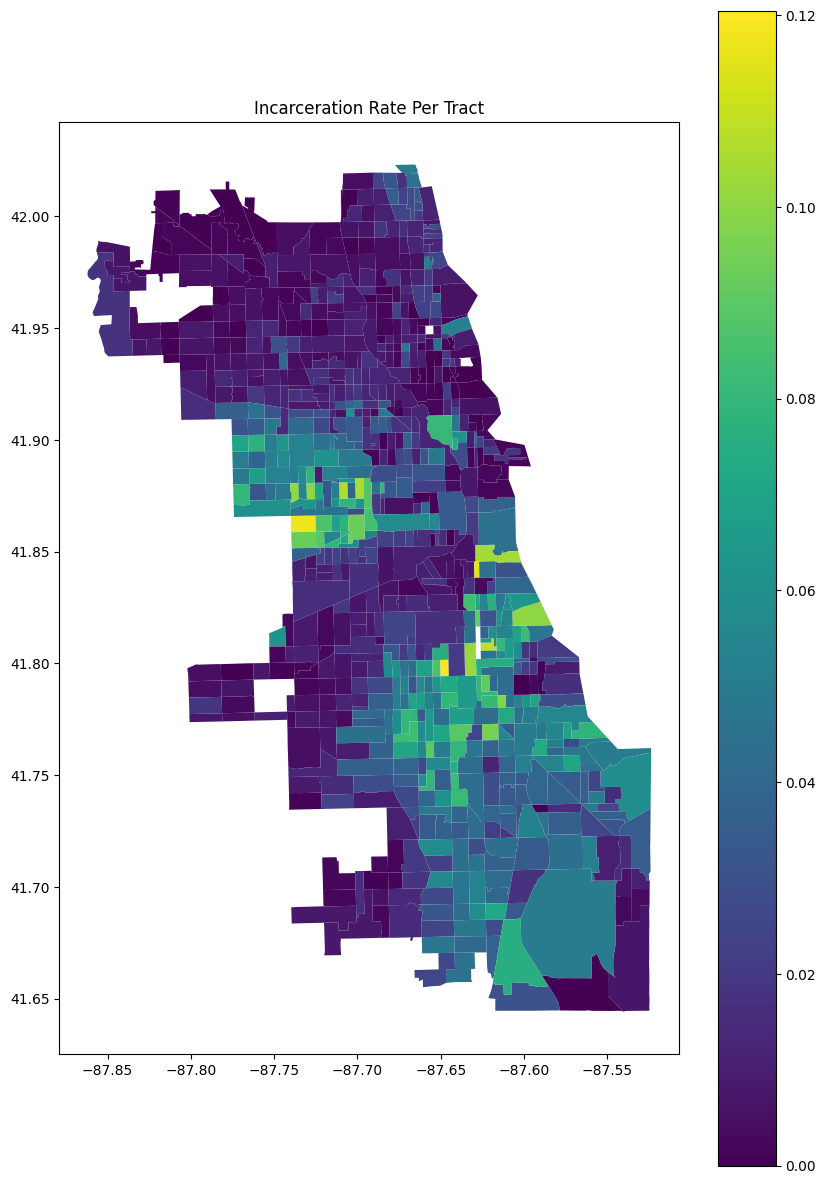

In [146]:
incarceration_geo = census_df.merge(incarceration_stats[['Incarceration_Rate_rP_gP_pall', 'geoid10']], on='geoid10', how='outer')
fig, ax = plt.subplots(figsize=(10, 15))
# incarceration_geo[["geometry"]].plot(ax=ax, color='lightgrey', edgecolor='grey')
incarceration_geo[['Incarceration_Rate_rP_gP_pall', "geometry"]].plot('Incarceration_Rate_rP_gP_pall', ax=ax, legend=True)
plt.title("Incarceration Rate Per Tract")
plt.savefig("../figures/incarceration_per_tract.png")
plt.show()
